# U-Net from scratch

In [11]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

# Dataset

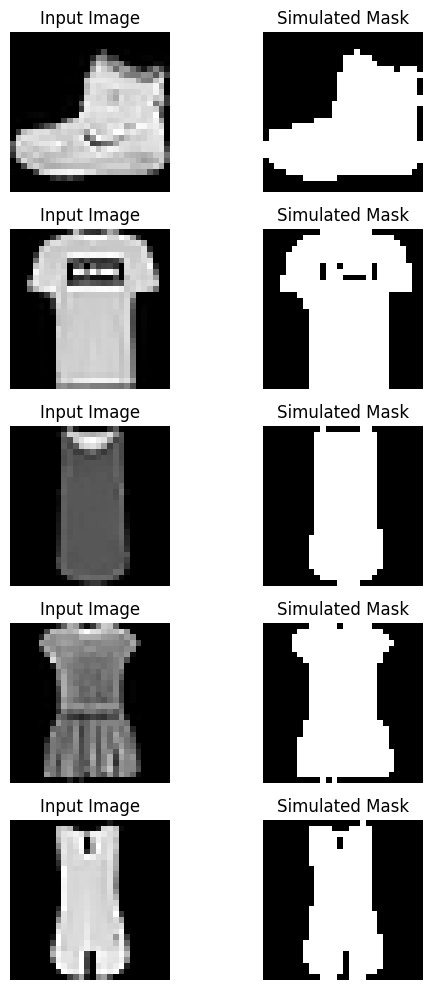

In [ ]:
from torch.utils.data import Subset
import numpy as np


# Simulate segmentation by thresholding pixel intensity
class FashionSegmentationDataset(Dataset):
    def __init__(self, train=True):
        self.data = torchvision.datasets.FashionMNIST(
            root="./data", train=train, download=True, transform=transforms.ToTensor()
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, _ = self.data[idx]
        mask = (img > 0.1).float()  # threshold to simulate item segmentation
        return img, mask

def visualize_dataset_samples(dataset, num_samples=5):
    fig, axs = plt.subplots(num_samples, 2, figsize=(6, 2 * num_samples))

    for i in range(num_samples):
        image, mask = dataset[i]
        axs[i, 0].imshow(image.squeeze(), cmap='gray')
        axs[i, 0].set_title("Input Image")
        axs[i, 1].imshow(mask.squeeze(), cmap='gray')
        axs[i, 1].set_title("Simulated Mask")
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Call it right after creating the dataset
train_ds = FashionSegmentationDataset(train=True)
visualize_dataset_samples(train_ds)


In [10]:
len(train_ds)

60000

# New metrics

## Dice loss

![Dice loss](./images/diceloss.png)

## IoU (Intersection over Union)

![IoU metric](./images/iou.png)

In [5]:
# Dice Loss
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, preds, targets, smooth=1.):
        preds = preds.contiguous()
        targets = targets.contiguous()
        
        intersection = (preds * targets).sum(dim=(2, 3))
        dice = (2. * intersection + smooth) / (preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) + smooth)
        return 1 - dice.mean()

# IoU metric
def iou_score(preds, targets, threshold=0.5, eps=1e-6):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

# U-net architecture

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1), nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = DoubleConv(1, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(64, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv(64, 32)

        self.final = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.up2(b)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        return torch.sigmoid(self.final(d1))


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Full dataset
full_train_ds = FashionSegmentationDataset(train=True)

# Use only 20% of the dataset
subset_size = int(0.2 * len(full_train_ds))
subset_indices = np.random.choice(len(full_train_ds), subset_size, replace=False)

# Subset and DataLoader
train_ds = Subset(full_train_ds, subset_indices)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

model = UNet().to(device)
dice_loss = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 5

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_iou = 0
    for imgs, masks in train_dl:
        imgs, masks = imgs.to(device), masks.to(device)

        preds = model(imgs)
        loss = dice_loss(preds, masks)
        iou = iou_score(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_iou += iou

    print(f"Epoch {epoch+1} | Dice Loss: {epoch_loss/ len(train_dl):.4f} | IoU: {epoch_iou / len(train_dl):.4f}")


Epoch 1 | Dice Loss: 0.0730 | IoU: 0.8917
Epoch 2 | Dice Loss: 0.0127 | IoU: 0.9777
Epoch 3 | Dice Loss: 0.0070 | IoU: 0.9878
Epoch 4 | Dice Loss: 0.0042 | IoU: 0.9928
Epoch 5 | Dice Loss: 0.0029 | IoU: 0.9952


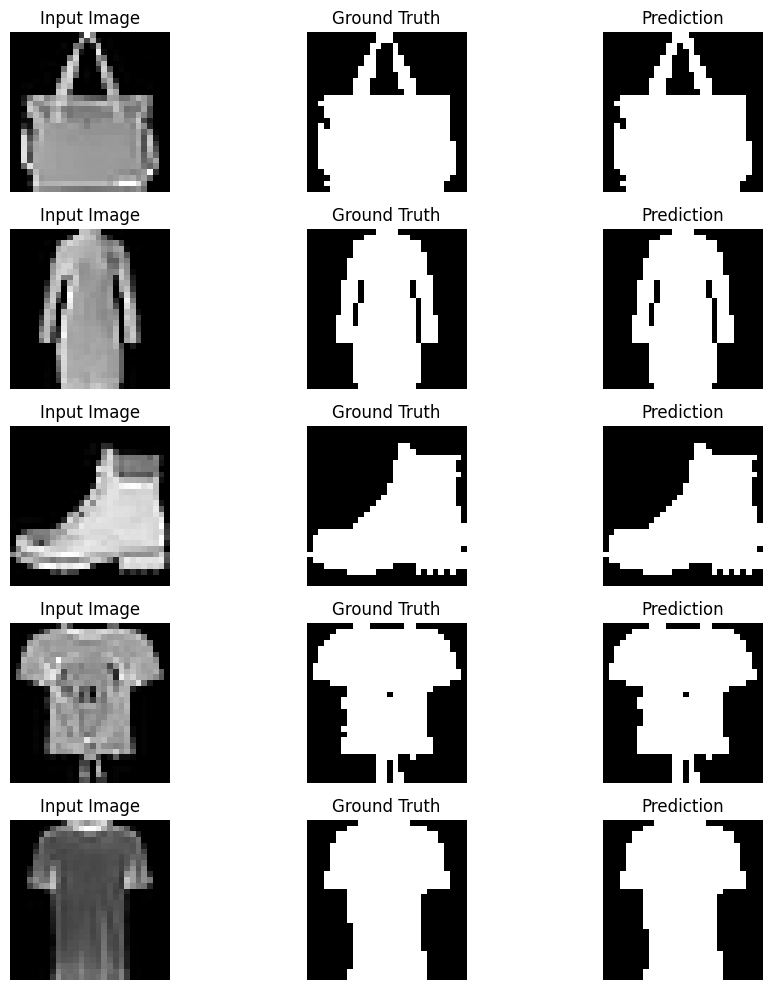

In [14]:
def visualize_results(model, dataset, device, num_samples=5):
    model.eval()
    fig, axs = plt.subplots(num_samples, 3, figsize=(10, 2 * num_samples))

    for i in range(num_samples):
        image, mask = dataset[i]
        with torch.no_grad():
            pred = model(image.unsqueeze(0).to(device))
            pred_mask = (pred.squeeze().cpu().numpy() > 0.5).astype(float)

        axs[i, 0].imshow(image.squeeze(), cmap='gray')
        axs[i, 0].set_title("Input Image")
        axs[i, 1].imshow(mask.squeeze(), cmap='gray')
        axs[i, 1].set_title("Ground Truth")
        axs[i, 2].imshow(pred_mask, cmap='gray')
        axs[i, 2].set_title("Prediction")

        for j in range(3):
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
visualize_results(model, train_ds, device)
